# Group D S1 - Twitter Crypto Analysis using Spark

# Sections
* [Description](#0)
* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Import necessary library](#1.2)
  * [1.3 Create SparkSession](#1.3)
* [2. Analysis](#2)
  * [2.1 Create the Dataframe](#2.1)
  * [2.2 Perform Analytics](#2.2)
      * [2.2.1 Frequency of tweets and price relation analysis](#2.2.1)
      * [2.2.2 Sentiment Analysis](#2.2.2)
      * [2.2.3 Location Analysis](#2.2.3)
      * [2.2.4 Emoji Analysis](#2.2.4)
* [3. TearDown](#3)
  * [3.1 Stop Hadoop](#3.1)

<a id='0'></a>
## Description


<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Import necessary library

Import neccessary python library that will be used in this project

In [3]:
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization
import findspark
findspark.init()
from pyspark.sql.functions import *
from datetime import datetime
import pytz
import pandas as pd
import os
from pyspark.sql.session import SparkSession
import re # for regular expression
from pyspark.sql import functions as F
from textblob import TextBlob # for sentiment analysis
from collections import Counter 

In [4]:
# changing pandas max column width property to improve data displaying
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession

By setting this environment variable we can include extra libraries in our Spark cluster

In [5]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

Creating the SparkSession

In [6]:
spark = (SparkSession.builder
    .appName("Twitter Analytics - DataFrames")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
    .config("spark.sql.legacy.timeParserPolicy","LEGACY")
    .enableHiveSupport()
    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<a id='2'></a>
## 2. Analysis

<a id='2.1'></a>
### 2.1 Create the DataFrames

Create the DataFrames that we will use in this project<br/>

In [7]:
# reading tweets json data from hdfs
tweets = (spark.read
               .json("hdfs://localhost:9000//datalake/raw/tweets/2021/12/*"))
tweets.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- display_url: string (nul

In [8]:
# show top 1 tweet
tweets.show(1)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+-------------+----------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quote_count|quo

In [9]:
# reading crypto prices from hdfs
prices = spark.read.options(delimiter=';',header=True).\
csv("hdfs://localhost:9000//datalake/raw/tweets/extra_data/crypto_price.csv")
prices.printSchema()

root
 |-- DATES: string (nullable = true)
 |-- BTC: string (nullable = true)
 |-- ETH: string (nullable = true)
 |-- FLOKI: string (nullable = true)
 |-- DOGE: string (nullable = true)



In [18]:
# show prices data
prices.toPandas()

,DATES,BTC,ETH,FLOKI,DOGE
0,2021-12-01,50516.62,4039.1912,0.000146608,0.18436
1,2021-12-02,49954.71,3969.9528,0.000176264,0.184536
2,2021-12-03,47441.12,3713.7848,0.000192896,0.17710
3,2021-12-04,43404.35,3625.2392,0.000134552,0.157432
4,2021-12-05,43622.27,3694.5216,0.000128568,0.150744
5,2021-12-06,41934.32,3477.3288,0.000109824,0.1408
6,2021-12-07,44915.40,3823.79,0.00013161,0.15650
7,2021-12-08,44535.1,3913.98,0.00012619,0.15790


In [19]:
# reading emojis data from hdfs
df_emoji = spark.read.options(delimiter=',',header=True).\
csv("hdfs://localhost:9000//datalake/raw/tweets/extra_data/Emoji_Sentiment_Data.csv")
df_emoji = df_emoji.select('Emoji').toPandas()

In [20]:
#show list of emojis
df_emoji.head()

,Emoji
0,😂
1,❤
2,♥
3,😍
4,😭


<a id='2.2'></a>
### 2.2 Perform Analytics

**Total number of tweets**<br/>



In [21]:
# number of tweets in our dataframe
tweets.count()

237048

#### Change 'created_at' format to date type

In [23]:
'''function that transforms the tweets 'created_at' from type string to date format yyyy-mm-dd so that we can group by
   by the date'''
def getDate(x):
    if x is not None:
        return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d"))
    else:
        return None

# Since we created a function that extract date form created_at we have to change it to sparks user defined function
date_fn = udf(getDate)

In [25]:
# create column date that we will use it for the groupby
tweets = tweets.withColumn("date", to_date(to_utc_timestamp(date_fn("created_at"),"UTC")))

In [27]:
# show distinct date we have in our dataset
tweets.select('date').distinct().toPandas()

,date
0,2021-12-04
1,2021-12-08
2,2021-12-01
3,2021-12-03
4,2021-12-07
5,2021-12-02
6,2021-12-06


<a id='2.2.1'></a>
### 2.2.1 Frequency of tweets and price relation analysis

#### Number of tweets in each hashtags

In [33]:
df = (tweets
      .select(explode("entities.hashtags.text").alias("hashtag"))
      .groupBy(upper("hashtag").alias('hashtag'))
      .agg(count("*").alias("total"))
      .orderBy(desc("total"))
      .limit(10))
df.toPandas()

,hashtag,total
0,ETH,43808
1,BTC,27180
2,FLOKI,13928
3,BITCOIN,13069
4,NFT,12471
5,DOGE,12139
6,CRYPTO,10839
7,BSC,9904
8,BNB,9191
9,NFTS,7786


#### Number of tweets for each hashtags in each day

In [34]:
tweets_filtered = (tweets
      .select('date',explode("entities.hashtags.text").alias("hashtag"))
      .groupBy("date",upper("hashtag").alias('hashtag'))
      .agg(count("*").alias("count"))
      .orderBy(asc("date"))
      .filter(col('hashtag').isin(['ETH','BTC','FLOKI','DOGE'])))
tweets_filtered_df = tweets_filtered.toPandas()
tweets_filtered_df

,date,hashtag,count
0,2021-12-01,DOGE,96
1,2021-12-01,ETH,124
2,2021-12-01,BTC,409
3,2021-12-01,FLOKI,314
4,2021-12-02,FLOKI,1589
5,2021-12-02,ETH,3763
6,2021-12-02,BTC,2435
7,2021-12-02,DOGE,1270
8,2021-12-03,FLOKI,5633
9,2021-12-03,DOGE,4270


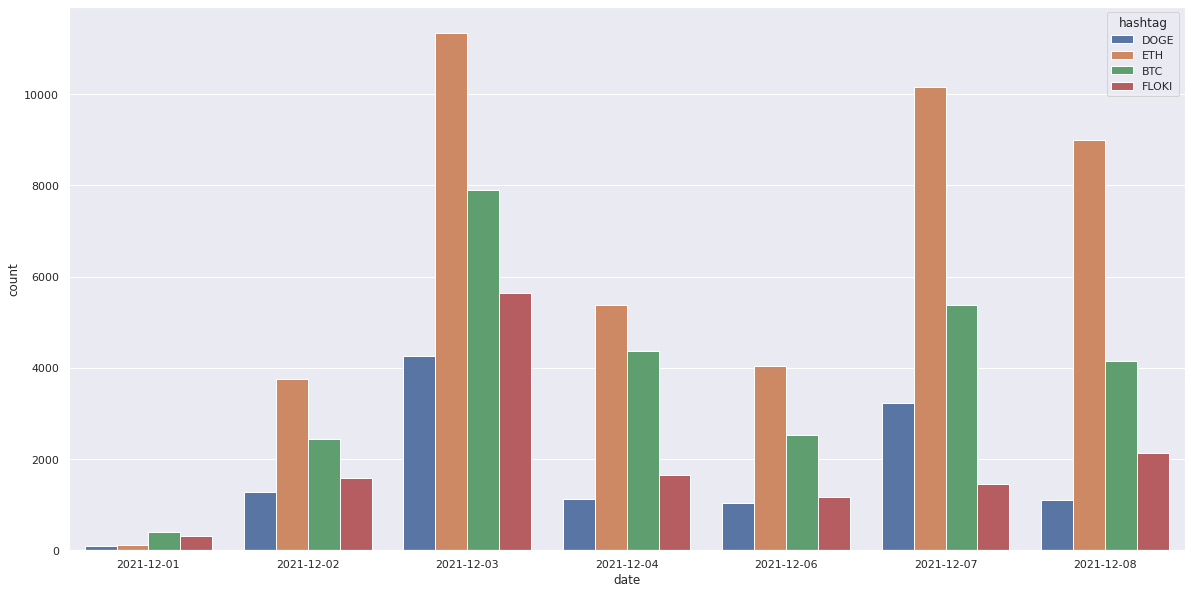

In [35]:
#bar plot of the count of tweets depending on crypto hashtag by date
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='date',y='count',hue='hashtag',data= tweets_filtered_df)
plt.show()

####  Transpose prices date for better analysis

In [37]:
prices = prices.withColumn('mapCol', \
                        create_map(lit('BTC'),prices.BTC,
                                    lit('ETH'),prices.ETH,
                                    lit('FLOKI'),prices.FLOKI,
                                    lit('DOGE'),prices.DOGE
                                   ) 
                  )
#Use explode function to explode the map 
res = prices.select('DATES',explode(prices.mapCol).alias('hashtag','price'))
res = res.withColumnRenamed('DATES', 'date')
res.toPandas()

,date,hashtag,price
0,2021-12-01,BTC,50516.62
1,2021-12-01,ETH,4039.1912
2,2021-12-01,FLOKI,0.000146608
3,2021-12-01,DOGE,0.18436
4,2021-12-02,BTC,49954.71
5,2021-12-02,ETH,3969.9528
6,2021-12-02,FLOKI,0.000176264
7,2021-12-02,DOGE,0.184536
8,2021-12-03,BTC,47441.12
9,2021-12-03,ETH,3713.7848


In [38]:
# join count of hashtag dataframe with price dataframe
new_df = tweets_filtered.join(res, on=['date', 'hashtag'], how='inner').orderBy(asc('date'))
new_df = new_df.toPandas()

In [39]:
new_df

,date,hashtag,count,price
0,2021-12-01,DOGE,96,0.18436
1,2021-12-01,ETH,124,4039.1912
2,2021-12-01,BTC,409,50516.62
3,2021-12-01,FLOKI,314,0.000146608
4,2021-12-02,FLOKI,1589,0.000176264
5,2021-12-02,ETH,3763,3969.9528
6,2021-12-02,BTC,2435,49954.71
7,2021-12-02,DOGE,1270,0.184536
8,2021-12-03,FLOKI,5633,0.000192896
9,2021-12-03,DOGE,4270,0.17710


<AxesSubplot:xlabel='date', ylabel='price'>

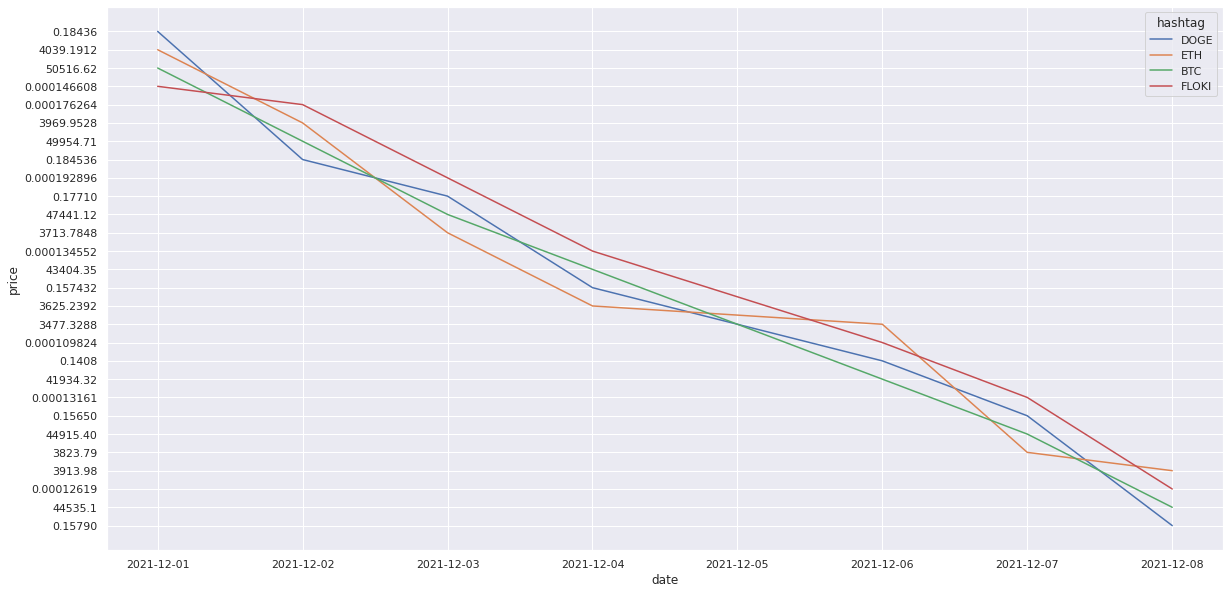

In [68]:
# time series plot of prices of each hashtag 
sns.lineplot(x='date', y='price', hue='hashtag', data=new_df)

<AxesSubplot:xlabel='date', ylabel='count'>

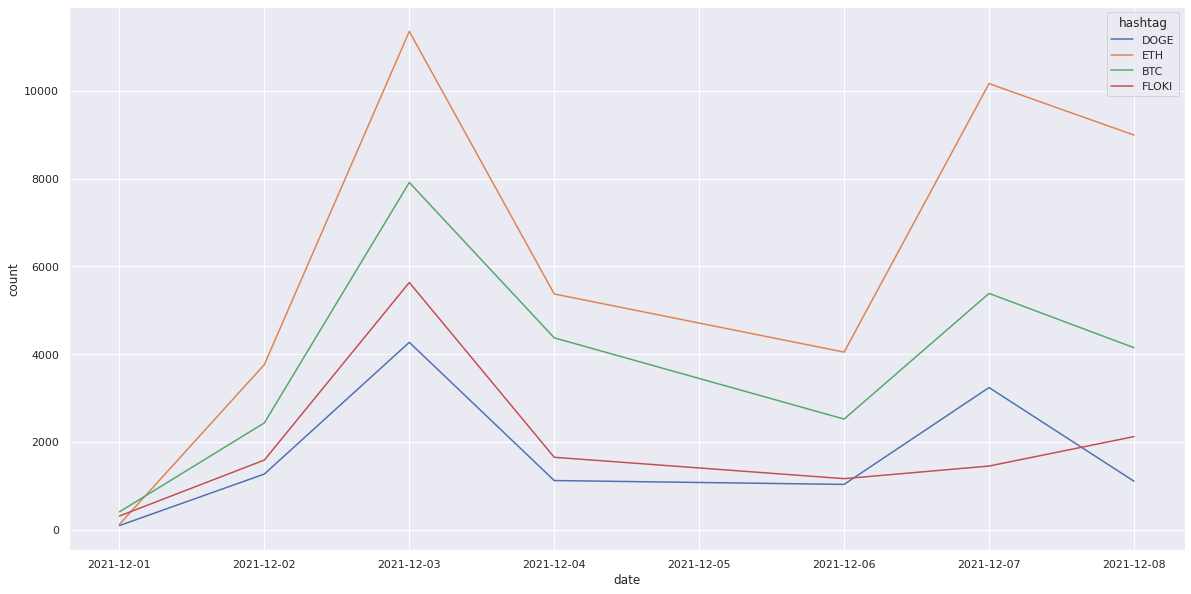

In [41]:
sns.lineplot(x='date', y='count', hue='hashtag', data=new_df)

<a id='2.2.2'></a>
###  2.2.2 Sentiment Analysis 

####  Text Cleaning

In [42]:
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@â'
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'bit.ly/\S+', '', tweet) 
    tweet = tweet.strip('[link]') 
    return tweet
def remove_users(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet
def remove_punctuation(tweet):
    tweet = re.sub('['+my_punctuation + ']+', '', tweet) 
    return tweet
def remove_number(tweet):
    tweet = re.sub('([0-9]+)', '', tweet) 
    return tweet
def remove_hashtag(tweet):
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet
    
# register user defined function
remove_links=udf(remove_links)
remove_users=udf(remove_users)
remove_punctuation=udf(remove_punctuation)
remove_number=udf(remove_number)
remove_hashtag=udf(remove_hashtag)

clean_tweets=tweets.withColumn('processed_text', remove_links(tweets['text']))
clean_tweets=clean_tweets.withColumn('processed_text', remove_users(clean_tweets['processed_text']))
clean_tweets=clean_tweets.withColumn('processed_text', remove_punctuation(clean_tweets['processed_text']))
clean_tweets=clean_tweets.withColumn('processed_text', remove_number(clean_tweets['processed_text']))


In [45]:
tweets.select('lang').show(5)

+----+
|lang|
+----+
|  en|
|  en|
|  en|
| und|
|  en|
+----+
only showing top 5 rows



In [44]:
# show one processed text 
clean_tweets.select('processed_text').head(1)

[Row(processed_text='  💸 #ETH   DAYS    \n\n✅RT  Follow me     \n\n🏆  Winners amp   💰\n\nPrize will be given only after reaching  RT…')]

####  Grouping by date and hashtag then append the processed text together to do sentiment analysis

In [62]:
tweets_with_text = (clean_tweets.filter(col('lang') == 'en')
      .select('date',explode("entities.hashtags.text").alias("hashtag"),'processed_text')
      .groupBy("date",upper("hashtag").alias('hashtag'))
      .agg(F.concat_ws(" ", F.collect_list(clean_tweets['processed_text'])).alias("processed_text"))
      .orderBy(asc("date"))
      .filter(col('hashtag').isin(['ETH','BTC','FLOKI','DOGE'])))
tweets_with_text.show()

+----------+-------+--------------------+
|      date|hashtag|      processed_text|
+----------+-------+--------------------+
|2021-12-01|   DOGE| Pick one #crypto...|
|2021-12-01|    ETH|  for only one tw...|
|2021-12-01|    BTC| DAILY from Staki...|
|2021-12-01|  FLOKI|  #floki sleeping...|
|2021-12-02|   DOGE| First of many ar...|
|2021-12-02|  FLOKI|  have many big p...|
|2021-12-02|    ETH| #Christmax givea...|
|2021-12-02|    BTC| #Christmax givea...|
|2021-12-03|    ETH| #BabyDogeCoin Wo...|
|2021-12-03|   DOGE|Keep you #BTC rea...|
|2021-12-03|    BTC| Gifting  each to...|
|2021-12-03|  FLOKI| is your chance f...|
|2021-12-04|    ETH| Drop your ETH Wa...|
|2021-12-04|    BTC| Mononoke Inu Mem...|
|2021-12-04|   DOGE| It’s #BlackFrida...|
|2021-12-04|  FLOKI| Here is my submi...|
|2021-12-06|    ETH| Top  #Cryptocurr...|
|2021-12-06|  FLOKI| If I send you  r...|
|2021-12-06|   DOGE| Giving away usd ...|
|2021-12-06|    BTC| Giving away usd ...|
+----------+-------+--------------

#### Sentiment analyis for each hashtag in each date

In [51]:

def polarity_detection(text):
    sent = TextBlob(text).sentiment.polarity
    neutral_threshold = 0.05
    
    if sent >= neutral_threshold:
        return "positive"
    elif sent > -neutral_threshold:
        return "neutral"
    else:
        return "negative"
    
def subjectivity_detection(text):
    subj = TextBlob(text).sentiment.subjectivity
    neutral_threshold = 0.5
    if subj >= neutral_threshold:
        return "positive"
    elif subj == neutral_threshold:
        return "neutral"
    else:
        return "negative"
polarity_detection_udf = udf(polarity_detection)
subjectivity_detection_udf = udf(subjectivity_detection)


tweets_with_text = tweets_with_text.withColumn("polarity", polarity_detection_udf(tweets_with_text['processed_text']))
tweets_with_text = tweets_with_text.withColumn("subjectivity", subjectivity_detection_udf(tweets_with_text['processed_text']))

tweets_with_text.show()

+----------+-------+--------------------+--------+------------+
|      date|hashtag|      processed_text|polarity|subjectivity|
+----------+-------+--------------------+--------+------------+
|2021-12-01|   DOGE| Pick one #crypto...|positive|    negative|
|2021-12-01|    ETH|Top  #Cryptocurre...|positive|    negative|
|2021-12-01|    BTC| DAILY from Staki...|positive|    negative|
|2021-12-01|  FLOKI| #FLOKI #KISHU or...|positive|    positive|
|2021-12-02|  FLOKI|  have many big p...|positive|    negative|
|2021-12-02|    ETH|  is now on YouWa...|positive|    negative|
|2021-12-02|    BTC|  is now on YouWa...|positive|    negative|
|2021-12-02|   DOGE| First of many ar...|positive|    negative|
|2021-12-03|  FLOKI| When you see goo...|positive|    positive|
|2021-12-03|   DOGE|Keep you #BTC rea...|positive|    negative|
|2021-12-03|    BTC| Shill me with th...|positive|    negative|
|2021-12-03|    ETH| drop your wallet...|positive|    positive|
|2021-12-04|  FLOKI|  have many big p...

<a id='2.2.3'></a>
## 2.2.3 Location Analysis

In [52]:
# see top users location
tweets.select('user.location').show(5)

+---------------+
|       location|
+---------------+
|           null|
|       Thailand|
|           null|
|Kansas City, MO|
|    jaimpancity|
+---------------+
only showing top 5 rows



#### Count of tweets from each country in which geolaction sharing is enabled

In [53]:
tweeets_location = (tweets.select("place.country_code",'place.country').filter(tweets['place.country_code'] != '').
                    groupby('country_code','country').
                    agg(count("*").alias("count")).orderBy(desc("count")).limit(10))

tweets_location_df = tweeets_location.toPandas()
tweets_location_df

,country_code,country,count
0,US,United States,54
1,ID,Indonesia,43
2,BD,Bangladesh,33
3,TR,Türkiye,23
4,IN,India,20
5,GB,United Kingdom,10
6,AE,United Arab Emirates,9
7,TR,Turkey,7
8,NG,Nigeria,6
9,KR,대한민국,5


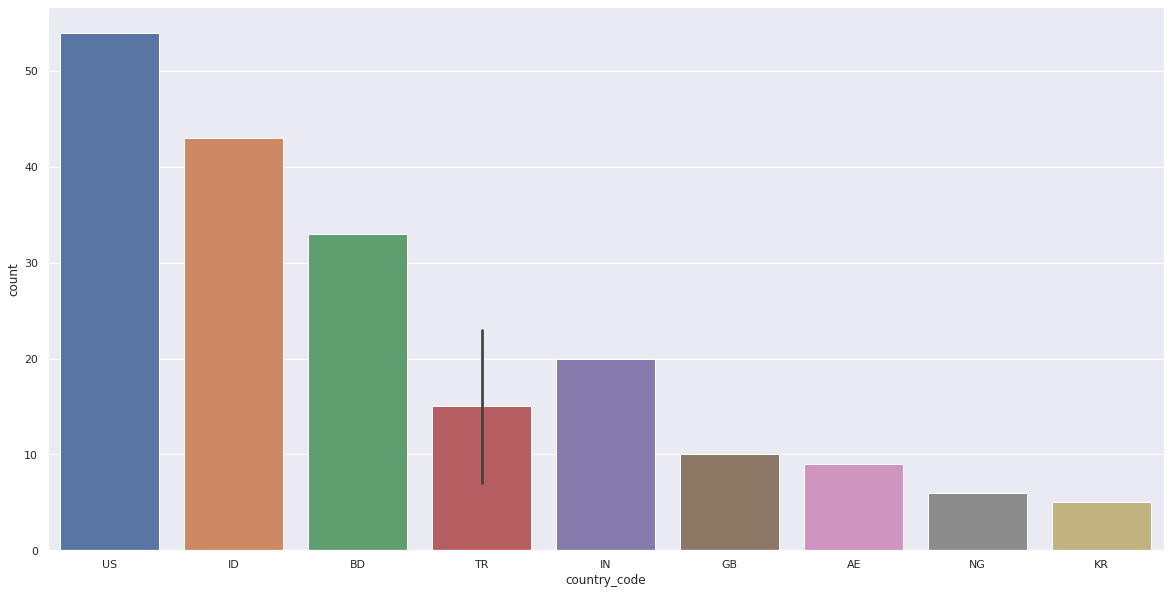

In [56]:
sns.barplot(x='country_code',y='count',data= tweets_location_df)
plt.show()

<a id='2.2.4'></a>
### 2.2.4 Emoji Analysis

#### Creating a list of emojis from pandas dataframe emoji

In [58]:
emoji_list = list(df_emoji.Emoji.values)
print(emoji_list)

['😂', '❤', '♥', '😍', '😭', '😘', '😊', '👌', '💕', '👏', '😁', '☺', '♡', '👍', '😩', '🙏', '✌', '😏', '😉', '🙌', '🙈', '💪', '😄', '😒', '💃', '💖', '😃', '😔', '😱', '🎉', '😜', '☯', '🌸', '💜', '💙', '✨', '😳', '💗', '★', '█', '☀', '😡', '😎', '😢', '💋', '😋', '🙊', '😴', '🎶', '💞', '😌', '🔥', '💯', '🔫', '💛', '💁', '💚', '♫', '😞', '😆', '😝', '😪', '�', '😫', '😅', '👊', '💀', '😀', '😚', '😻', '©', '👀', '💘', '🐓', '☕', '👋', '✋', '🎊', '🍕', '❄', '😥', '😕', '💥', '💔', '😤', '😈', '►', '✈', '🔝', '😰', '⚽', '😑', '👑', '😹', '👉', '🍃', '🎁', '😠', '🐧', '☆', '🍀', '🎈', '🎅', '😓', '😣', '😐', '✊', '😨', '😖', '💤', '💓', '👎', '💦', '✔', '😷', '⚡', '🙋', '🎄', '💩', '🎵', '➡', '😛', '😬', '👯', '💎', '🌿', '🎂', '🌟', '🔮', '❗', '👫', '🏆', '✖', '☝', '😙', '⛄', '👅', '♪', '🍂', '💏', '🔪', '🌴', '👈', '🌹', '🙆', '➜', '👻', '💰', '🍻', '🙅', '🌞', '🍁', '⭐', '▪', '🎀', '━', '☷', '🐷', '🙉', '🌺', '💅', '🐶', '🌚', '👽', '🎤', '👭', '🎧', '👆', '🍸', '🍷', '®', '🍉', '😇', '☑', '🏃', '😿', '│', '💣', '🍺', '▶', '😲', '🎸', '🍹', '💫', '📚', '😶', '🌷', '💝', '💨', '🏈', '💍', '☔', '👸', '🇪', '░', '🍩', '👾', '☁', '🌻', '😵',

In [59]:
# function that extract emoji from the text
def extract_emoji(text):
    # setup the input, get the characters and the emoji lists
    allchars = [str for str in text]
    clean_emoji = ''.join([str for str in allchars if any(i in str for i in emoji_list)])
    return clean_emoji

#udf declaration of extract_emoji function
extract_emoji = udf(extract_emoji)


#### Creating a column that has emojis only and showing top five

In [61]:
emoji_within_tweets=tweets.withColumn('emoji_only', extract_emoji(tweets['text']))
emoji_within_tweets.select('emoji_only').show(5)

+----------+
|emoji_only|
+----------+
|   💸✅🏆💰|
|    🔥🔥🎨|
|      ❤😍❤|
|          |
|        😊|
+----------+
only showing top 5 rows



#### Grouping by date and hashtag then append the the emojis together 

In [63]:
tweets_with_emoji = (emoji_within_tweets
      .select('date',explode("entities.hashtags.text").alias("hashtag"),'emoji_only')
      .groupBy("date",upper("hashtag").alias('hashtag'))
      .agg(F.concat_ws(" ", F.collect_list(emoji_within_tweets['emoji_only'])).alias("emojis"))
      .orderBy(asc("date"))
      .filter(col('hashtag').isin(['ETH','BTC','FLOKI','DOGE'])))
tweets_with_emoji.show()

+----------+-------+--------------------+
|      date|hashtag|              emojis|
+----------+-------+--------------------+
|2021-12-01|   DOGE|👇               ...|
|2021-12-01|    BTC|   👇   😅😅😅  ?...|
|2021-12-01|    ETH|                 ...|
|2021-12-01|  FLOKI|  🚀 👇    ❤   😌...|
|2021-12-02|  FLOKI|         📈💪 😮 ...|
|2021-12-02|    ETH|  👈 ♪ 🌴✨🌊🏄💌?...|
|2021-12-02|   DOGE|   💰   ⭐👉💵💰 ⭐...|
|2021-12-02|    BTC| ♪              ❌...|
|2021-12-03|    ETH|  💸💸 💸✅🏆💰  ?...|
|2021-12-03|    BTC| 👇💎   😊 😊✅ 😊...|
|2021-12-03|   DOGE| 🐶🔥🔥 ✅ ✅ ✅ ✅ ✅...|
|2021-12-03|  FLOKI|💎     😊💋💋💋❗?...|
|2021-12-04|    ETH|🔥🔥📈📈✅ 🔥🔥📈?...|
|2021-12-04|    BTC|🔥🔥📈📈✅ 🔥🔥📈?...|
|2021-12-04|   DOGE| 🚀🚀🚀🚀🚀💥💥💥...|
|2021-12-04|  FLOKI|                 ...|
|2021-12-06|    ETH|     🔴🔴🔴🔴🔴  ...|
|2021-12-06|  FLOKI|                 ...|
|2021-12-06|   DOGE|           🎉 ⏳🐕...|
|2021-12-06|    BTC|       🎉   🔴🔴?...|
+----------+-------+--------------------+
only showing top 20 rows



In [65]:
# function that count emojis and select top 5 emojis
def count_emoji(emoji_text):
    count = Counter(emoji_text)
    return ''.join([elem[0] for elem in count.most_common(6)])
count_emoji = udf(count_emoji)

#### Create a column with top 5 emojis 

In [66]:
tweets_with_top_emoji=tweets_with_emoji.withColumn('top_5_emoji', count_emoji(tweets_with_emoji['emojis']))
tweets_with_top_emoji.select('date','hashtag','top_5_emoji').toPandas()

,date,hashtag,top_5_emoji
0,2021-12-01,DOGE,🔥💸🎉🚀🐶
1,2021-12-01,ETH,🚀💎😍🐶🔥
2,2021-12-01,BTC,🚀❤🍀🚨🔥
3,2021-12-01,FLOKI,🚀🔥❤💎👑
4,2021-12-02,FLOKI,💪🚀⚽🔥😮
5,2021-12-02,ETH,🚀✅🏆❤✨
6,2021-12-02,BTC,🚀🔥🌳🔻💻
7,2021-12-02,DOGE,🚀🐕💎👀🔥
8,2021-12-03,FLOKI,🚀✅🔥❤💎
9,2021-12-03,DOGE,🚀✅🔥📈👀


**Top 10 users with more tweets posted**<br/>


In [128]:
df = (tweets
          .groupBy("user.screen_name")
          .agg(max("user.statuses_count").alias("tweets_posted"))
          .orderBy(desc("tweets_posted"))
          .limit(10))
df.toPandas()

,screen_name,tweets_posted
0,AlertTrade,2473404
1,CryptoTraderPro,2365545
2,thirdbrainfx,2358169
3,gocoo_59,2290971
4,cybersec_feeds,1959754
5,SJB6991,1650810
6,Gambiste1,1565722
7,5SecondsOfSummo,1517695
8,bmurphypointman,1475776
9,xaelbot,1369979


**Top 10 users with more followers**<br/>

In [129]:
df = (tweets
          .groupBy("user.screen_name")
          .agg(max("user.followers_count").alias("followers_count"))
          .orderBy(desc("followers_count"))
          .limit(10))
df.toPandas()

,screen_name,followers_count
0,CoinMarketCap,3808324
1,BTCTN,2062029
2,whale_alert,1843776
3,CoinsSpace_,837984
4,AirdropStario,743019
5,DogecoinRise,487981
6,stevedabitcoin,468324
7,Poloniex,428094
8,maxkeiser,421652
9,ashwsbreal,389501


<a id='3'></a>
## 3. Tear Down

Once we complete the the lab we can stop all the services

<a id='3.1'></a>
### 3.1 Stop Hadoop

Stop Hadoop

Open a terminal and execute
```sh
hadoop-stop.sh
```